# Event generation

## Setup the environment

In [1]:
#Color printing
from termcolor import colored

#General utility libraries
import os, sys, subprocess, time

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants
from particle import Particle
import ROOT

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#Helper function to supress Pythia messages
def makePythiaSilent(pythia):
    pythia.ReadString("Init:showMultipartonInteractions = off")
    pythia.ReadString("Init:showChangedParticleData = off")
    pythia.ReadString("Init:showProcesses = off")
    pythia.ReadString("Init:showChangedSettings = off")
    pythia.ReadString("Next:numberShowInfo = 0")
    pythia.ReadString("Next:numberShowProcess = 0")
    pythia.ReadString("Next:numberShowEvent = 0")
    pythia.ReadString("Next:numberCount = 0")

Welcome to JupyROOT 6.24/04


# Run Pythia8 from ROOT interface

Prepare and initialize pythia configuration for generation of $p+p$ events at 13.6 TeV (as in LHC in 2022):

 * create `TPythia8` object managing the Pythia
 * enable all hadronic interactions with`HardQCD:all` setting
 * initialize pythia to simulate $p+p$ collisions at 13.6 TeV
 * fix random number generator seed to a fixed value to get the same results every time

In [2]:
#Create Pythia control object
pythia = ROOT.TPythia8(False)

#Disable messages
makePythiaSilent(pythia)

#Set configurations parameters
pythia.ReadString("Random:setSeed = on")
pythia.ReadString("Random:seed = 99")

#Set list of enabled physics processes
pythia.ReadString("HardQCD:all = on")

#Set the initial particles PDG id and
#energy in center of mass system in GeV
pdgId_beam1 = int(Particle.from_evtgen_name("p+").pdgid)
pdgId_beam2 = int(Particle.from_evtgen_name("p+").pdgid)
sqrtS = 13600 #GeV
pythia.Initialize(pdgId_beam1 , pdgId_beam2, sqrtS)

#Prepare space for list of final and intermediate state particles
nParticles = 1000
particles = ROOT.TClonesArray("TParticle", nParticles)

 PYTHIA Warning in PhaseSpace2to2tauyz::trialKin: maximum for cross section violated  
 PYTHIA Warning in MultipartonInteractions::init: maximum increased by factor 1.211


* generate a single event
* list the event history
* import the particle list into ```particles``` list
* print the total number of particles to check the consistensy with the listing

In [3]:
pythia.GenerateEvent()
pythia.EventListing()
pythia.ImportParticles(particles,"All")
print(colored("There are {} particles in the events history", "blue").format(particles.GetEntries()))

There are 306 particles in the events history

 --------  PYTHIA Event Listing  (complete event)  ---------------------------------------------------------------------------------
 
    no         id  name            status     mothers   daughters     colours      p_x        p_y        p_z         e          m 
     0         90  (system)           -11     0     0     0     0     0     0      0.000      0.000      0.000  13600.000  13600.000
     1       2212  (p+)               -12     0     0    50     0     0     0      0.000      0.000   6800.000   6800.000      0.938
     2       2212  (p+)               -12     0     0    51     0     0     0      0.000      0.000  -6800.000   6800.000      0.938
     3         21  (g)                -21    20     0     5     6   102   101      0.000      0.000      0.286      0.286      0.000
     4         21  (g)                -21    21    21     5     6   104   103      0.000      0.000    -20.576     20.576      0.000
     5         21  (g)

## Consistency checks

**Please:**

calculate and print:

* total energy of stable particles
* total momentum of stable particles

**Note:** stable particles have `status==91` in Pythia8, but `StatusCode==1` in ROOT

**Hints:** 

* use ```filter()``` Python function to create filtered collections:

```Python
filteredCollection = filter(lambda x: x.someMethod(), aCollection)
for x in filteredCollection:
    print(x)
```    
    
* use 
```ROOT.Math.PxPyPzEVector()``` for four momentum representation and related operations  

In [4]:
...

print(colored("Total four momentum:","blue"),"({:1.3f},{:1.3f},{:1.3f},{:1.3f})".format(totalMom.Px(),totalMom.Px(),totalMom.Px(),totalMom.E()))

Total four momentum: (-0.000,-0.000,-0.000,13600.000)


Make a plot of invartiant mass of all photon pairs.

1) select photons
2) calculate invartiant mass of all possible photon pairs
3) skip the cases when the pair ic compoted of the same photon taken twice
4) fill ```ROOT.TH1F()``` with pair invariant mass. 
5) plot the histogram

How can you interpret the result? 

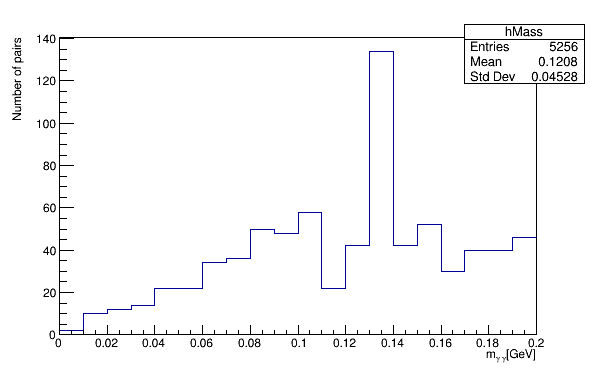

In [5]:
#create a histogram
hMass = ROOT.TH1F("hMass",";m_{#gamma #gamma}[GeV];Number of pairs",20,0,0.2)

#define epsilon for removal of pairs with 0 invariant mass.
#Since the 0 is a "numerical zero" we need a finite epsilon
epsilon = 1E-3

#Loop over first photons
#select photons from particle list
photonPDGId = int(Particle.from_evtgen_name("gamma").pdgid)
photons1 = filter(lambda aPart: aPart.GetStatusCode()==1 and aPart.GetPdgCode()==photonPDGId, particles)

for aPart1 in photons1:
    #create fourmomentum of the first photon
    part1_p4 = ROOT.Math.PxPyPzEVector(aPart1.Px(), aPart1.Py(), aPart1.Pz(), aPart1.Energy())
    #Loop over second photon
    photons2 = filter(lambda aPart: aPart.GetStatusCode()==1 and aPart.GetPdgCode()==photonPDGId, particles)
    for aPart2 in photons2:
        #create fourmomentum of the second photon
        part2_p4 = ROOT.Math.PxPyPzEVector(aPart2.Px(), aPart2.Py(), aPart2.Pz(), aPart2.Energy())  
        
        #sum photon fourmomenta
        totalMom = part1_p4 + part2_p4
        
        #fill histo if the total fourmomentum mas positive mass, i.e this is not a photon
        if totalMom.M()>epsilon:
            hMass.Fill(totalMom.M())
            
        #remove the momentum of current photon from the pair  
        totalMom -= ROOT.Math.PxPyPzEVector(aPart2.Px(), aPart2.Py(), aPart2.Pz(), aPart2.Energy())

aCanvas = ROOT.TCanvas( 'aCanvas', 'Example plots', 600, 400)
aCanvas.Draw()
hMass.Draw()

**Please:**

* make the mass histogram only for the pairs originating from the decay of the same particle

**Hint:**
* use mother index ```TParticle::GetFirstMother()``` to identify the mother particle:

```Python
motherIdx_part1 = aPart1.GetFirstMother()
```

Warning in <TROOT::Append>: Replacing existing TH1: hMass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: aCanvas


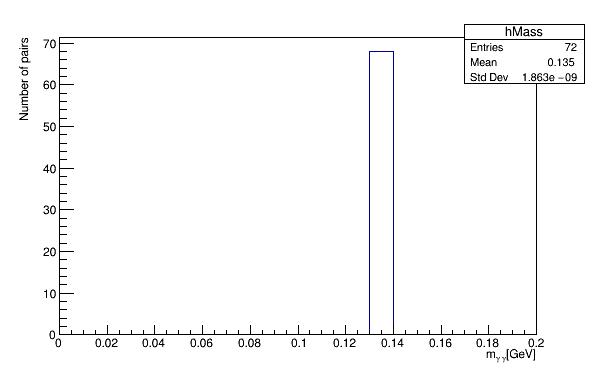

In [6]:
...
pass

## Particle decay controls

* disable $\pi^{0}$ decays to two photons
* enable $\pi^{0} \rightarrow 4e$ (see what is branching ratio of this decay)
* check the event history listing if the $\pi^{0}$ decays are correct

In [7]:
pythia = ROOT.TPythia8(False)
makePythiaSilent(pythia)

pythia.ReadString("Random:setSeed = on")
pythia.ReadString("Random:seed = 99")

pythia.ReadString("HardQCD:all = on")
pythia.ReadString("111:onMode = off")
pythia.ReadString("111:onIfMatch = 11 11 11 11")
pdgId_beam1 = int(Particle.from_evtgen_name("p+").pdgid)
pdfId_beam2 = int(Particle.from_evtgen_name("p+").pdgid)
sqrtS = 13600 #GeV
pythia.Initialize(pdgId_beam1 , pdgId_beam1, sqrtS)
pythia.GenerateEvent()
pythia.EventListing()
particles.Clear()
pythia.ImportParticles(particles,"All")

383

 *** TDatabasePDG::AddParticle: particle with PDGcode=90 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900110 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900210 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900220 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900330 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900440 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9902110 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9902210 already defined
 PYTHIA Warning in PhaseSpace2to2tauyz::trialKin: maximum for cross section violated  
 PYTHIA Warning in MultipartonInteractions::init: maximum increased by factor 1.211

 --------  PYTHIA Event Listing  (complete event)  ---------------------------------------------------------------------------------
 
    no         id  name            status     mothers   daughters     colo

### $\pi^{0}$ lifetime analysis

Distance between the $\pi^{0}$ production and decay position can be used to calculate the particle lifetime: 

$$
\Large{
N(t) = N_{0} e^{\frac{-t^{*}}{\tau}} = N_{0} e^{\frac{-d}{\gamma \beta c \tau}} = N_{0} e^{\frac{-mcd}{pc\tau}}
}
$$
where:
$$
t^{*} - \text{ time measured in the particle rest frame}\\
p, E - \text{pion momentum and energy}
$$

* find production vertices of $\pi^{0}$
* find production vertices of electrons from $\pi^{0}$ (= decay vertices of $\pi^{0}$)
* calculate distance between production and decay of $\pi^{0}$
* plot histogram of number of particle wrt. time in the rest frame: $t^{*} = \frac{mc}{p}\frac{d}{c} = \frac{mc^{2}}{pc}\frac{d}{c}$
* fit exponential function: $f(t^{*}) = e^{-t^{*}/\tau}$
* calculate the $\pi^{0}$ life time from the fit parameters
* compare result with the PDG value

Warning in <TCanvas::Constructor>: Deleting canvas with same name: aCanvas


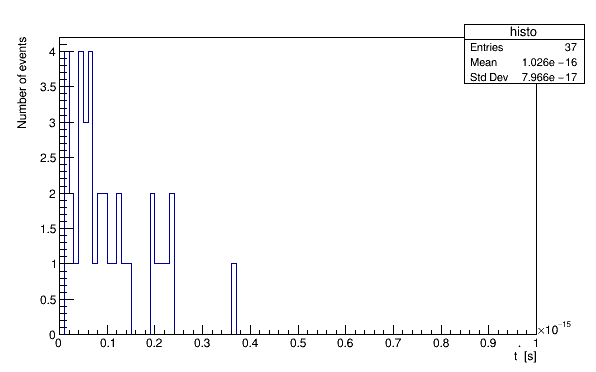

In [8]:
def fillHisto(histo, particles):
    pionPDGId = int(Particle.from_evtgen_name("pi0").pdgid)
    pions = filter(lambda aPart: aPart.GetPdgCode()==pionPDGId, particles)
    c = scipy_constants.physical_constants["speed of light in vacuum"][0] # m/s
    mm_to_m = 1E-3 # mm = 1E-3 m

    for aPart in pions:
        p4 = ROOT.Math.PxPyPzEVector(aPart.Px(), aPart.Py(), aPart.Pz(), aPart.Energy())
        productionVertex = ROOT.Math.PxPyPzEVector(aPart.Vx(), aPart.Vy(), aPart.Vz(), aPart.T())
        daughter = particles[aPart.GetFirstDaughter()]
        decayVertex = ROOT.Math.PxPyPzEVector(daughter.Vx(), daughter.Vy(), daughter.Vz(), daughter.T())
        t = (decayVertex-productionVertex).R()*mm_to_m*p4.M()/p4.P()/c
        histo.Fill(t)

histo = ROOT.TH1D("histo","; t^{*} [s];Number of events",100,0,1E-15)      
fillHisto(histo, particles)       
        
canvas = ROOT.TCanvas( 'aCanvas', 'Example plots', 600, 400) 
canvas.Draw()
histo.Draw()

A single event contains only a few $\pi^{0}$ mesons. One needs more data to make a precise estimate.

**Please**:

* generate 1000 events
* fill histogram with $\pi^{0}$ decay time in ints rest frame using the ```fillHisto(...)``` function
* plot histogram with Y axis in log scale - check ROOT documentation for a correct method
* read out the $\pi^{0}$ life time from the histogram statistics

CPU times: user 8.68 s, sys: 67.8 ms, total: 8.74 s
Wall time: 8.76 s
 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame  
 PYTHIA Error in StringFragmentation::fragmentToJunction: caught in junction flavour loop  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Warning in <TROOT::Append>: Replacing existing TH1: histo (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: aCanvas


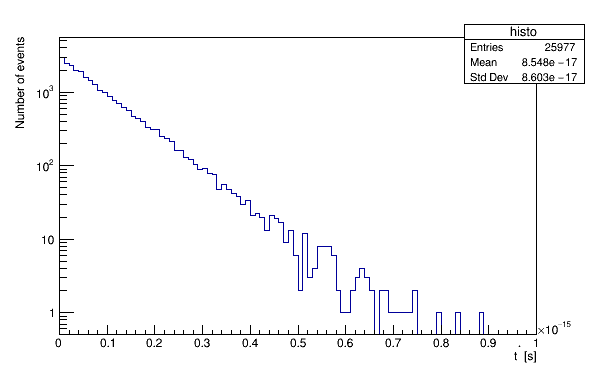

In [9]:
%%time

nEvents = 1000
histo = ROOT.TH1D("histo","; t^{*} [s];Number of events",100,0,1E-15)  
...
pass

* fit an exponential function to the histogram
* read the $\pi^{0}$ life time from the fit parameters

None
Fitted pi0 life time: 8.46E-17 s
Formula based function:     fitFunc 
              fitFunc : expo Ndim= 1, Npar= 2, Number= 200 
 Formula expression: 
	exp([logNorm]+[1/tau]*x) 
 FCN=88.5905 FROM MIGRAD    STATUS=CONVERGED      56 CALLS          57 TOTAL
                     EDM=7.25288e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  logNorm      8.02699e+00   8.75108e-03   2.87243e-05  -1.82218e-03
   2  1/tau       -1.18208e+16   7.28379e+13   5.63659e+09  -9.78470e-20


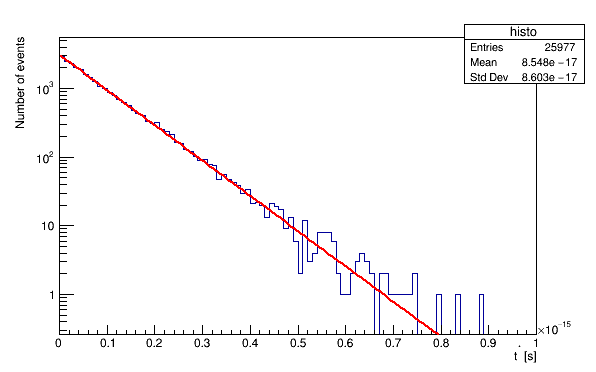

In [10]:
#define function to fit
fitFunc = ROOT.TF1("fitFunc","expo",0,1E-15)

#name the parameters
fitFunc.SetParName(0,"logNorm")
fitFunc.SetParName(1,"1/tau")

#set the initial parameters values
fitFunc.SetParameter("N",1)
fitFunc.SetParameter("1/tau",1)

#print the function formula
print(fitFunc.Print())

#perform the fit
histo.Fit("fitFunc")

#extract the parameter value 
tau = -1.0/fitFunc.GetParameter("1/tau")

print(colored("Fitted pi0 life time:","blue"),"{:.2E} s".format(tau))

canvas.Draw()
canvas.SetLogy()
histo.Draw()
#draw the function on the histogram plot
#option "same" keeps the histogram
fitFunc.Draw("same")

## Homework

Use Pythia to generate events from $e^{+}e^{-}$ collisions at the "Z boson peak:" $\sqrt{s} = m_{Z}$. Try to generate 10 000 events, but first estimate how long it will take.

* enable only the Z boson exchange with parameter ```WeakSingleBoson:ffbar2gmZ```
* disable all Z boson decays
* enable only the $Z \rightarrow e^{+}e^{-}$ decay
* find the stable electron in the event history

For the selected decay product:

* plot probability density of the polar angle: $\frac{1}{\sigma}\frac{d\sigma}{d\cos (\theta)}$
* plot probability density of the transverse momentum: $\frac{1}{\sigma}\frac{d\sigma}{dp_{T}}$. 
Overlay with probability distribution for transverse momentum calculated in the same way as in homework for Monte Carlo methods.

Make plots for two Pythia settings:

* with final state radiation ```with FSR```
* without final state radiation: ```without FSR```

Compare the plots with the events generated in homework for Monte Carlo methods.

In [11]:
#Check PDG id of particles used in the exercise
Z0PDGId = int(Particle.from_evtgen_name("Z0").pdgid)
electronPDGId = int(Particle.from_evtgen_name("e-").pdgid)
positonPDGId = int(Particle.from_evtgen_name("e+").pdgid)

#Define some helper functions 
def configurePythia(pythia, sqrtS, isFSR):
...

def findStableElectrons(particles): 
...

def generateAndSelect(nEvents):
    electrons = []
...
    return electrons    

In [12]:
%%time

#Generate events and fill arrays with variables of interest
nEvents = int(1E5)

m_Z = 91.881 #GeV
sqrtS = m_Z
pythia = ROOT.TPythia8(False)
makePythiaSilent(pythia)

nParticles = 1000
particles = ROOT.TClonesArray("TParticle", nParticles)
...
pass

CPU times: user 14 s, sys: 344 ms, total: 14.4 s
Wall time: 14.4 s
 *** TDatabasePDG::AddParticle: particle with PDGcode=90 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900110 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900210 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900220 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900330 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900440 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9902110 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9902210 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=90 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900110 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900210 already defined
 *** TDatabasePDG::AddParticle: particle with PDGcode=9900220 already defined
 *** TD

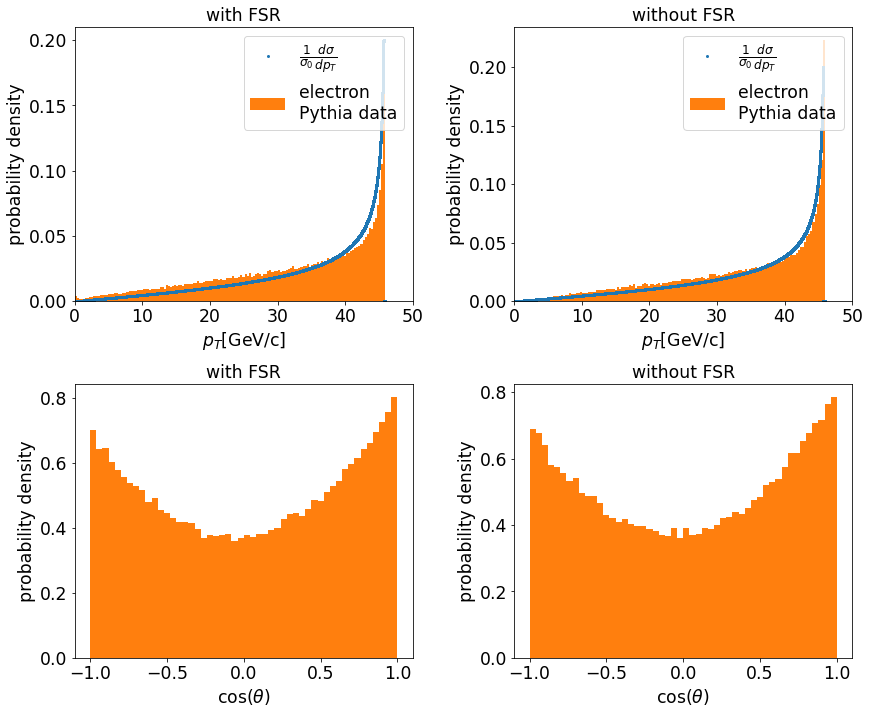

In [13]:
#Make plots.
#Use a separate cell to avoid event regeneration each time a plot is updated

fig, axes = plt.subplots(2,2, figsize=(12, 12))
...
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3, hspace=0.3)   